In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !pip install appdirs==1.4.3 asn1crypto==0.24.0 attrs==18.2.0 Automat==0.7.0 backcall==0.1.0 bleach==3.0.2 certifi==2018.10.15 cffi==1.11.5 chardet==3.0.4 cloudpickle==0.6.1 colorama==0.4.0 constantly==15.1.0 cryptography==2.3.1 cycler==0.10.0 Cython==0.29 dask==0.20.0 decorator==4.3.0 defusedxml==0.5.0 entrypoints==0.2.3 html5lib==1.0.1 hyperlink==18.0.0 idna==2.7 imageio==2.4.1 incremental==17.5.0 ipykernel==5.1.0 ipython==7.1.1 ipython-genutils==0.2.0 jedi==0.13.1 Jinja2==2.10 jsonschema==2.6.0 jupyter-client==5.2.3 jupyter-core==4.4.0 kiwisolver==1.0.1 MarkupSafe==1.0 matplotlib==3.0.1 mistune==0.8.4 mkl-fft==1.0.6 mkl-random==1.0.1 nbconvert==5.4.0 nbformat==4.4.0 networkx==2.2 notebook==5.7.0 numpy==1.15.3 olefile==0.46 pandas==0.23.4 pandocfilters==1.4.2 parso==0.3.1 pickleshare==0.7.5 Pillow==5.3.0 prometheus-client==0.4.2 prompt-toolkit==2.0.7 pyasn1==0.4.4 pyasn1-modules==0.2.2 pycosat==0.6.3 pycparser==2.19 Pygments==2.2.0 PyHamcrest==1.9.0 pyOpenSSL==18.0.0 pyparsing==2.2.2 PySocks==1.6.8 python-dateutil==2.7.3 pytz==2018.5 PyWavelets==1.0.1 pywinpty==0.5.4 pyzmq==17.1.2 requests==2.19.1 ruamel.yaml==0.15.77 scikit-image==0.14.0 scikit-learn==0.20.0 scipy==1.1.0 Send2Trash==1.5.0 service-identity==17.0.0 simplegeneric==0.8.1 six==1.11.0 terminado==0.8.1 testpath==0.4.2 toolz==0.9.0 torch==0.4.1 torchvision==0.2.1 tornado==5.1.1 tqdm==4.28.1 traitlets==4.3.2 Twisted==18.9.0 urllib3==1.23 wcwidth==0.1.7 webencodings==0.5.1 win-inet-pton==1.0.1 wincertstore==0.2 zope.interface==4.5.0

In [0]:
# # http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 23.9MB/s 


In [0]:
# !pip install torch==0.4.1 torchvision==0.2.1

In [0]:
# !pip install Pillow==4.0.0
# !pip install PIL
# !pip install image
# from PIL import Image

In [0]:
# %matplotlib inline
import numpy as np
# import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision

from torchvision.models import resnet

import yaml

import os
from pathlib import Path
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output, display

In [0]:
num_output_regressors = 9+3

# use the GPU if available
if torch.cuda.is_available():
    device_to_use = torch.device('cuda')
else:
    device_to_use = torch.device('cpu')

device_to_use

device(type='cuda')

In [0]:
# get the original resnet from the examples
res_model = resnet.resnet50(pretrained=False, num_classes=num_output_regressors).to(device=device_to_use)
# model

In [0]:
# an alternative way of editing the network
# currently not used

# remove the last layer, that was used for classification
# and replace it with a layer, that has six outputs for regression of the 6d-pose
# also remember to move the model to the GPU
# last_removed = list(model.children())[:-2]
# model_2 = torch.nn.Sequential(*last_removed)
# add an adaptive pooling layer, to support varying image sizes
# model_2 = torch.nn.Sequential(*model_2, torch.nn.AdaptiveAvgPool2d(7))#.cuda()
# model_2 = torch.nn.Sequential(*model_2, torch.nn.Linear(512, num_output_regressors))#.cuda()
#model_2 = torch.nn.Sequential(*model_2, torch.nn.Linear(512, 1000))#.cuda()
#model_2

In [0]:
# add a loss function
loss_fun = torch.nn.MSELoss().to(device=device_to_use)

# add an optimizer
optimizer = torch.optim.Adadelta(res_model.parameters())

In [0]:
class TLessDataset(Dataset):
    """ Dataset-Class for T-Less datset """
    
    def __init__(self, gt_file, rgb_dir, depth_dir, device, transform=None):
        """
        Args:
            gt_file (string): File which stores the ground truth as yaml
        """
        # store where we want to save our data
        assert isinstance(device, torch.device)
        self.device = device
        # read in the position data
        self.R_and_t_combined = []
        
        print("Reading in pose data")
        stream = open(gt_file, "r")
        docs = yaml.load_all(stream)
        for doc in docs:
            for k,v in doc.items():
                Rt_comb = [] + v[0]["cam_R_m2c"] + v[0]["cam_t_m2c"]
                self.R_and_t_combined.append(np.asarray(Rt_comb))
        
        # store the folders
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform
        print("Initialization Done")
    
    def __len__(self):
        return len(self.R_and_t_combined)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.rgb_dir, "{:04d}.png".format(idx))
        depth_path = os.path.join(self.depth_dir + "{:04d}.png".format(idx))
        
        assert os.path.isfile(rgb_path) == True
        assert os.path.isfile(depth_path) == True
        
        # get the images and bring them into shape, if they are not
        im_rgb = io.imread(rgb_path)
        im_depth = io.imread(depth_path)
        h, w = im_depth.shape
        im_depth = im_depth.reshape((h,w,1))
        
        # get the pose data
        R_t_data = self.R_and_t_combined[idx]
        
        sample = {"image_rgb": im_rgb, "image_depth": im_depth, "pose": R_t_data}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self, device):
        assert isinstance(device, torch.device)
        self.device = device

    def __call__(self, sample):
        im_rgb, im_depth, pose = sample['image_rgb'], sample['image_depth'], sample['pose']
        data_list = [im_rgb, im_depth, pose]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        data_list[0] = im_rgb.transpose((2, 0, 1))
        data_list[1] = im_depth.transpose((2, 0, 1))
        
        # apply transformations, that are the same for all parts
        for i in range(len(data_list)):
            # convert numpy arrays to torch (float) tensors
            data_list[i] = torch.from_numpy(data_list[i]).float()
            # now transfer them to the correct divice
            data_list[i] = data_list[i].to(self.device)
        
        return {'image_rgb': data_list[0],
                'image_depth': data_list[1],
                'pose': data_list[2]}
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        im_rgb, im_depth, pose = sample['image_rgb'], sample['image_depth'], sample['pose']

        h, w = im_rgb.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        im_rgb = transform.resize(im_rgb, (new_h, new_w))
        im_depth = transform.resize(im_depth, (new_h, new_w))
        
        return {'image_rgb': im_rgb,
                'image_depth': im_depth,
                'pose': pose}    

In [0]:
data_dir = '/content/drive/My Drive/t-less-data'
train_dir = '/'.join([data_dir, 't-less_v2_train_kinect_01'])
test_dir = '/'.join(['t-less_v2_test_kinect_01'])

In [0]:
# !ls '/content/drive/My Drive/t-less-data/t-less_v2_train_kinect_12 (1)/'

In [0]:
gt_file = '/'.join([train_dir, "01", 'gt.yml'])
rgb_dir = '/'.join([train_dir, "01", 'rgb/'])
depth_dir = '/'.join([train_dir, "01", 'depth/'])
print(depth_dir)

trafos = transforms.Compose([Rescale(224), ToTensor(device_to_use)])

t_less_01 = TLessDataset(gt_file, rgb_dir, depth_dir, device_to_use, transform=trafos)

/content/drive/My Drive/t-less-data/t-less_v2_train_kinect_01/01/depth/
Reading in pose data
Initialization Done


In [0]:
# split the data in training and test data
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42
num_workers = 0    # currently crashes when more than one worker is used

# Creating data indices for training and validation splits:
dataset_size = len(t_less_01)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(t_less_01, batch_size=batch_size, 
                          sampler=train_sampler, num_workers=num_workers)
validation_loader = DataLoader(t_less_01, batch_size=batch_size, 

                               sampler=validation_sampler, num_workers=num_workers)

In [0]:
import time

In [0]:
def print_time(start_time):
    """
    Prints total time taken given a start time point.
    :param start_time: Time, time.time()
    :param description: String, description of action which was timed
    :return void
    """
    end_time = time.time()
    total_time = end_time - start_time
    print("Total time taken: ", time.strftime("%H:%M:%S", time.gmtime(int(total_time))))

In [0]:
def train(model, batch_size, train_data_name, save_model_dir, num_epochs=1, train_loader=None):
  
    save_model_path = os.path.join(save_model_dir, "_".join(["trained_model_on", str(train_data_name), "with_params", 
                                                                 "epochs", str(num_epochs), 
                                                                 "batch", str(batch_size)]) + ".tar")

    training_start_time = time.time()

    loss_evolution = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        loss_evolution.append([])

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # increase batch size every x epochs to converge faster

            # get the inputs
            data_to_unpack = data
            img_rgb, img_depth, pose = data_to_unpack['image_rgb'], data_to_unpack['image_depth'], data_to_unpack['pose']
            #break

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(img_rgb)
            loss = loss_fun(outputs, pose)
            loss.backward()
            optimizer.step()

            # print statistics
            corrent_loss = loss.item()
            loss_evolution[epoch].append(corrent_loss)
            running_loss += corrent_loss
            print('Epoch: {:d}; Batch: {:d}; Avg. loss: {:.3f}'.format(epoch + 1, i+1, running_loss / len(loss_evolution[epoch])))
        clear_output(wait=True)
        print('Epoch: {:d}; Batch: {:d}; Avg. loss: {:.3f}'.format(epoch + 1, i+1, running_loss / len(loss_evolution[epoch])))

    print("Finished training.")
    print_time(training_start_time)

    # Save model
    print("Saving model to ", save_model_path)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'epoch': epoch,
    }, save_model_path)
    
    return model, loss_evolution

In [0]:
# Training

train_data_name = train_dir.split('/')[-1]
save_model_dir = os.path.join('/content/drive/My Drive/', 'saved_models')
if not os.path.isdir(save_model_dir):
  os.mkdir(save_dir)

# Hyperparameters
num_epochs = 10


# Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results. 
# If you wish to resuming training, call model.train() to ensure these layers are in training mode.

model, loss_evolution = train(res_model, batch_size, train_data_name, save_model_dir, num_epochs=num_epochs, train_loader=train_loader)


Epoch: 10; Batch: 65; Avg. loss: 69.363
Finished training.
Total time taken:  00:21:02
Saving model to  /content/drive/My Drive/saved_models/trained_model_on_t-less_v2_train_kinect_01_with_params_epochs_10_batch_16.tar


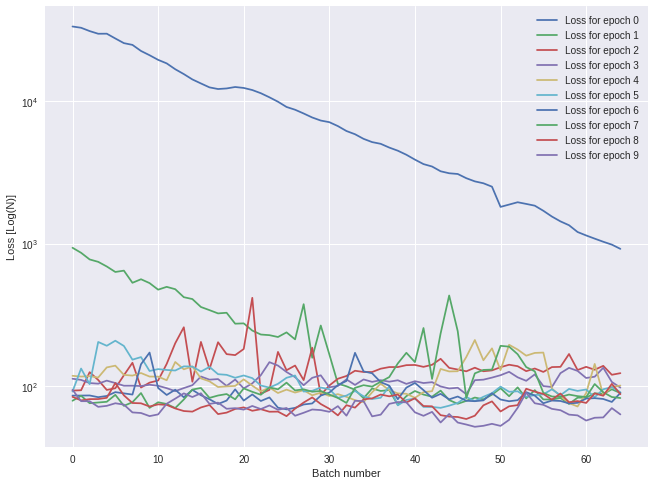

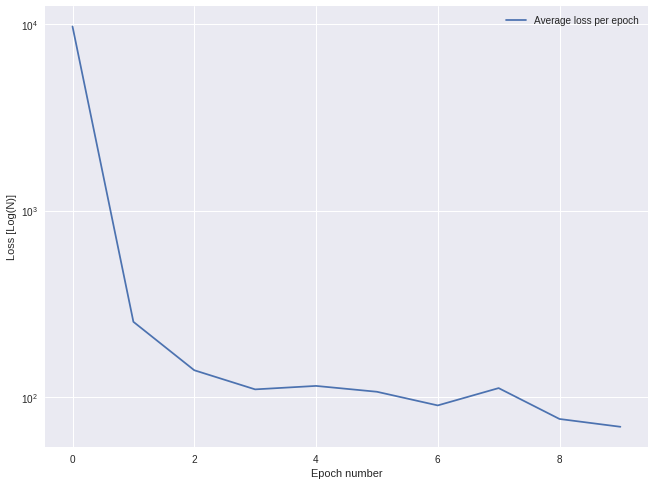

In [0]:
plot_size_factor = 0.9

loss_evolution = np.asarray(loss_evolution)

fig= plt.gcf()
fig.set_size_inches(plot_size_factor*9*4./3., plot_size_factor*9*1)
for i in range(len(loss_evolution)):
    plt.semilogy(np.arange(0, len(loss_evolution[i])), loss_evolution[i], label="Loss for epoch {}".format(i))

plt.xlabel("Batch number")
plt.ylabel("Loss [Log(N)]")
plt.legend()
plt.show()



avg_loss_per_epoch = loss_evolution.sum(axis=1)/loss_evolution.shape[1]

fig= plt.gcf()
fig.set_size_inches(plot_size_factor*9*4./3., plot_size_factor*9*1)
plt.semilogy(np.arange(0, len(avg_loss_per_epoch)), avg_loss_per_epoch, label="Average loss per epoch")
plt.xlabel("Epoch number")
plt.ylabel("Loss [Log(N)]")
plt.legend()
plt.show()

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 12])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 12])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 12])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 12])


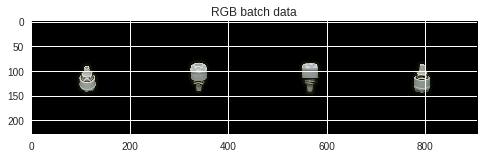

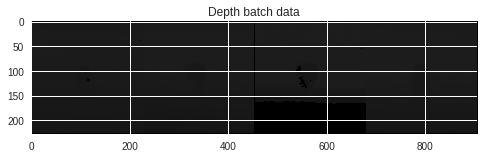

tensor([[ 8.8962e-01, -4.5592e-01,  2.6822e-02,  2.9876e-01,  6.2536e-01,
          7.2088e-01, -3.4544e-01, -6.3329e-01,  6.9254e-01, -4.6347e+00,
         -5.9617e+00,  6.3231e+02],
        [ 7.3013e-01, -6.8327e-01, -7.1174e-03, -2.9636e-01, -3.0726e-01,
         -9.0430e-01,  6.1570e-01,  6.6237e-01, -4.2683e-01, -6.6589e+00,
         -1.5350e+01,  6.3389e+02],
        [ 8.8166e-01, -4.7189e-01,  1.4044e-04, -3.6796e-02, -6.9045e-02,
         -9.9693e-01,  4.7045e-01,  8.7895e-01, -7.8238e-02, -6.3721e+00,
         -2.3555e+01,  6.4439e+02],
        [-7.6556e-01, -6.4304e-01, -2.0342e-02,  2.6038e-01, -3.3860e-01,
          9.0419e-01, -5.8831e-01,  6.8692e-01,  4.2665e-01, -5.7218e+00,
         -1.9513e+01,  6.4271e+02]])


In [0]:
# visualize some data

dataloader = DataLoader(t_less_01, batch_size=4,
                        shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image_rgb'].size(), sample_batched['image_depth'].size(), sample_batched['pose'].size())
    
    if i_batch == 3:
        data_list = sample_batched['image_depth'], sample_batched['image_rgb'], sample_batched['pose']
        data_list = list(data_list)
        
        for i in range(len(data_list)):
            data_list[i] = data_list[i].cpu()
        
        images_depth_batch, images_rgb_batch, pose_batch = data_list
        batch_size = len(images_rgb_batch)
        im_size = images_rgb_batch.size(2)

        grid = utils.make_grid(images_rgb_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.title("RGB batch data")
        plt.show()

        grid = utils.make_grid(images_depth_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.title("Depth batch data")
        plt.show()
        
        print(pose_batch)
        
        break

Reading in pose data
Initialization Done


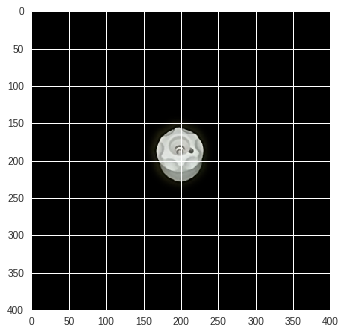

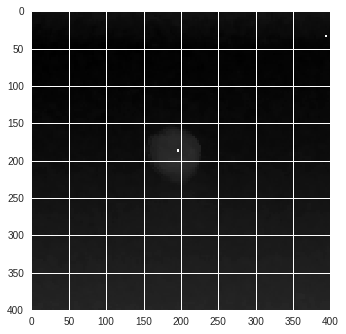

Pose:  tensor([  0.1984,  -0.9798,  -0.0249,  -0.8964,  -0.1711,  -0.4089,   0.3964,
          0.1034,  -0.9122,  -6.0573,  12.8339, 624.6863], device='cuda:0')


In [0]:
# some nicer visualization
# no tensor trafo here, otherwise it crashes

t_less_01_no_trafo = TLessDataset(gt_file, rgb_dir, depth_dir, device_to_use, transform=None)

ix = 200

plt.imshow(t_less_01_no_trafo[ix]['image_rgb'])
plt.show()

depth_im = t_less_01_no_trafo[ix]['image_depth']
depth_im = depth_im.reshape((depth_im.shape[0], depth_im.shape[1]))
plt.imshow(depth_im)
plt.show()

print("Pose: ", t_less_01[ix]['pose'])

In [0]:
# some left over code from testing
inVals = torch.randn(16,3,224,224).float().cuda()
inVals.shape

torch.Size([16, 3, 224, 224])

In [0]:
model(inVals)

tensor([[  8.5590,  -8.3158,  -8.6431,  -7.9666,   9.0838,  -8.7299,   7.9413,
          -8.9982,   8.2640, -13.4569,  46.2814, 605.5940],
        [  8.3587,  -8.0818,  -8.3359,  -8.1069,   8.8954,  -8.2603,   7.7154,
          -8.7077,   8.2953,  -9.4728, -56.4895, 616.7644],
        [  8.0337,  -7.8597,  -8.0220,  -7.8818,   8.6016,  -8.1129,   7.4607,
          -8.4030,   7.9191, -10.0070, -35.9883, 594.1423],
        [  8.9182,  -8.7141,  -8.9530,  -8.5304,   9.4948,  -9.0274,   8.2889,
          -9.3610,   8.7248, -12.8882,  14.8948, 644.2316],
        [  8.0125,  -7.7992,  -8.0000,  -7.6749,   8.5320,  -8.0625,   7.4092,
          -8.4177,   7.8814, -11.0689,  -0.2883, 579.7734],
        [  8.4113,  -8.2050,  -8.4003,  -8.2421,   8.9585,  -8.3819,   7.8226,
          -8.8042,   8.4156,  -9.3919, -63.2839, 625.9012],
        [  8.0590,  -7.9384,  -8.0673,  -7.9547,   8.6191,  -8.2405,   7.5623,
          -8.4614,   7.9125, -11.4282,  -1.1036, 592.4695],
        [  8.8393,  -8.6203

In [0]:
# read in the camera correction matrix
cam_Ks = []

stream = open(os.path.join(train_dir, "01", "info.yml"), "r")
docs = yaml.load_all(stream)
for doc in docs:
    for k,v in doc.items():
        # the data was saved row wise, now we need to convert it back to a 3x3 matrix
        # Notice: order="F" performs the row wise reshaping
        cam_matrix = np.asarray(v["cam_K"]).reshape((3,3))
        cam_Ks.append(cam_matrix)

In [0]:
# read in the position data
cam_R_m2c = []
cam_t_m2c = []
R_and_t_combined = []

stream = open(os.path.join(train_dir, "01", "gt.yml"), "r")
docs = yaml.load_all(stream)
for doc in docs:
    for k,v in doc.items():
        # the data was saved row wise, now we need to convert it back to a 3x3 matrix
        # Notice: order="F" performs the row wise reshaping
        R_matrix = np.asarray(v[0]["cam_R_m2c"])
        cam_R_m2c.append(R_matrix.reshape((3,3)))
        t_vec = np.asarray(v[0]["cam_t_m2c"])
        cam_t_m2c.append(t_vec)
        Rt_comb = [] + v[0]["cam_R_m2c"] + v[0]["cam_t_m2c"]
        R_and_t_combined.append(np.asarray(Rt_comb))

In [0]:
cam_R_m2c[0], cam_t_m2c[0], R_and_t_combined[0]

(array([[ 0.9993986 ,  0.01151922, -0.03270921],
        [ 0.00908361, -0.99724164, -0.07365909],
        [-0.03346753,  0.07331767, -0.99674678]]),
 array([ -9.36182955,  29.57068027, 627.46803893]),
 array([ 9.99398600e-01,  1.15192200e-02, -3.27092100e-02,  9.08361000e-03,
        -9.97241640e-01, -7.36590900e-02, -3.34675300e-02,  7.33176700e-02,
        -9.96746780e-01, -9.36182955e+00,  2.95706803e+01,  6.27468039e+02]))

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

KeyboardInterrupt: ignored

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records